In [66]:
import os
import sys
import subprocess

sys.path.append('../')

import pandas as pd
import geopandas as gpd
from src.diversities import *
import scipy.stats as ss
import pycodamath
import re

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn2
from src.plotting import *
from matplotlib.backends.backend_pdf import PdfPages

## MATPLOTLIB SETTINGS FOR PLOTTING CONSISTENTLY
sns.set_context("paper")

# fontsizes
title_fontsize = 16
legend_fontsize = 14
axis_title_fontsize = 14
default_fontsize = 12

plt.rc('font', size=default_fontsize)
plt.rc('axes', titlesize=axis_title_fontsize)
plt.rc('axes', labelsize = axis_title_fontsize)
plt.rc('xtick', labelsize=default_fontsize)
plt.rc('ytick', labelsize=default_fontsize)
plt.rc('legend', fontsize=legend_fontsize, title_fontsize=legend_fontsize)
plt.rc('figure', titlesize = title_fontsize)

# plot defaults
marker_size = 40

This notebook contains the code for running the analyses, creating tables and figures for the following sections:
* Figure 1: Abundances and beta-diversity of ARGs.
* Figure S1: Overview of sampling origins.
* Figure S2: ARGs shared between the different database sources.
* Figure S3: Classes of ARGs.
* Figure S4: Alpha-diversity measurements.
* Figure S5: Choropleth maps of ARG abundances.
* Figure S6: Pan- and core-resistomes.
* Figure S7: Additional PCA biplots.
* Table S1: PERMANOVA on ARG abundances and world regions.

In here, we are only using Python code (and some bash scripts).

In [2]:
# Set the directory of where dataframes are saved
data_dir = '../data/'

In [3]:
# Set the directory of where to save figures
fig_dir = '../fig'
os.makedirs(fig_dir, exist_ok=True)

# Data overviews

Contains code for:
* Descriptive statistics
* Figure S1
* Figure S2
* Figure S3

## Samples

In [4]:
metadata = pd.read_csv(os.path.join(data_dir, 'metadata_fixed.csv'), index_col=0).drop_duplicates(subset=['genepid', 'complete_name'])
geo_data = gpd.read_parquet(os.path.join(data_dir, 'gs3.parquet'))

/tmp/ipykernel_2349147/994916922.py:2: UserWarning: Multiple non-primary geometry columns read from Parquet/Feather file. The first column read was promoted to the primary geometry.
  geo_data = gpd.read_parquet(os.path.join(data_dir, 'gs3.parquet'))


In [5]:
countries =  gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

country2country = {
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Czech Republic': 'Czechia',
    "Ivory Coast": "Côte d'Ivoire",
    'Democratic Republic of the Congo': 'Dem. Rep. Congo',
    'Macedonia': 'North Macedonia' ,
    'United States': 'United States of America',
    
    
}
geo_data['country'] = geo_data['country'].replace(country2country)
countries['name'] = countries['name'].replace(country2country)

geoCitys = pd.DataFrame(metadata.groupby(['country', 'city']).genepid.nunique()).merge(geo_data[['country', 'city', 'gps_geometry']], on = ['country', 'city'], how='left')
geoCountries = pd.DataFrame(metadata.groupby(['country']).genepid.nunique()).merge(geo_data[['country', 'country_geometry']], on = ['country'], how='left')


/tmp/ipykernel_2349147/4057636839.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries =  gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


In [6]:
print("Samples:", metadata.genepid.nunique())
print("Cities:", metadata.city.nunique())
print("Cities:", metadata.country.nunique())
print("Regions:", metadata.Region.nunique())
print("Years:", metadata.year.nunique())

Samples: 1240
Cities: 350
Cities: 111
Regions: 7
Years: 6


### Figure S1

/tmp/ipykernel_2349147/1881904162.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


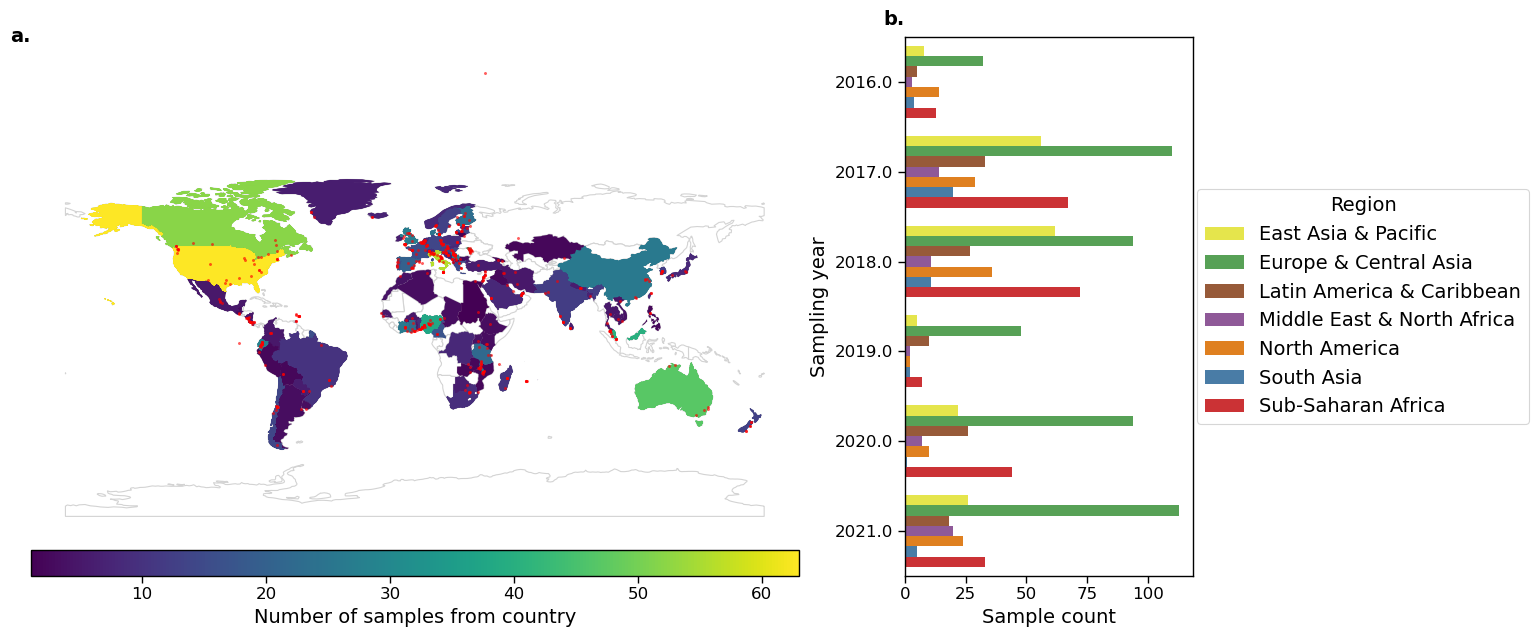

In [7]:
ncols = 2
nrows = 2
fig = plt.figure(figsize=(15,7))
#, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,7), gridspec_kw={'height_ratios': [1, .05], 'hspace': 0.01, 'width_ratios': [.8, .2]})

gs = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, 
    height_ratios=[1, .05], 
    hspace=-0.01, 
    width_ratios=[.8, .3],
    wspace = 0.2
)

ax_map = fig.add_subplot(gs[0,0])
ax_leg = fig.add_subplot(gs[1,0])

gpd.GeoDataFrame(countries, geometry='geometry').plot(color='white', edgecolor='lightgray', ax=ax_map)

gpd.GeoDataFrame(geoCountries, geometry='country_geometry').plot(
    column='genepid', 
    ax=ax_map,
    legend=True,
    cax = ax_leg,
    legend_kwds={
        "orientation": "horizontal",
        "label": "Number of samples from country"
    }
)

gpd.GeoDataFrame(
    geoCitys[['country', 'city', 'gps_geometry']], geometry='gps_geometry'
).plot(
    ax=ax_map,
    alpha = .5,
    markersize=2,
    color = 'red'
)

ax_map.axis('off')

ax_bar = fig.add_subplot(gs[:,1])

sns.barplot(
    data = pd.DataFrame(metadata.groupby(['Region','year']).genepid.nunique()).reset_index().rename(columns={'genepid': 'Sample count'}),
    x = 'Sample count',
    y = 'year',
    hue = 'Region',
    orient='horizontal',
    ax = ax_bar,
    palette = region_palette
)

ax_bar.legend(loc='center right', bbox_to_anchor=(2.2,.5), title="Region")
ax_bar.set_ylabel('Sampling year')

for ax, letter in zip([ax_map, ax_bar], alphabet):
    ax.text(-0.0, 1.05, letter + '.', transform=ax.transAxes, fontsize=axis_title_fontsize, va='top', ha='right', fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'sample_overview.png'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'sample_overview.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'sample_overview.tiff'), bbox_inches='tight')

## ARGs

In [8]:
dbgroup_palette, dbgroup_handles = make_palette(
    labels = ['ResFinder', 'Functional', 'Genera'],
    colors = ['#FC766AFF', '#5B84B1FF', '#1f77b4']
)

dbgroup_palette2, dbgroup_handles2 = make_palette(
    labels = ['Acquired', 'FG', 'Genera'],
    colors = ['#FC766AFF', '#5B84B1FF', '#1f77b4']
)


In [9]:
# Metadata for ARGs
sel_genesClusters = pd.read_csv('../data/panres_metadata_fixed.csv')
sel_genesClusters = sel_genesClusters.dropna(subset=['class'], axis='rows')
sel_genesClusters['class'] = sel_genesClusters['class'].apply(eval)

### Figure S2

/tmp/ipykernel_2349147/298421735.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


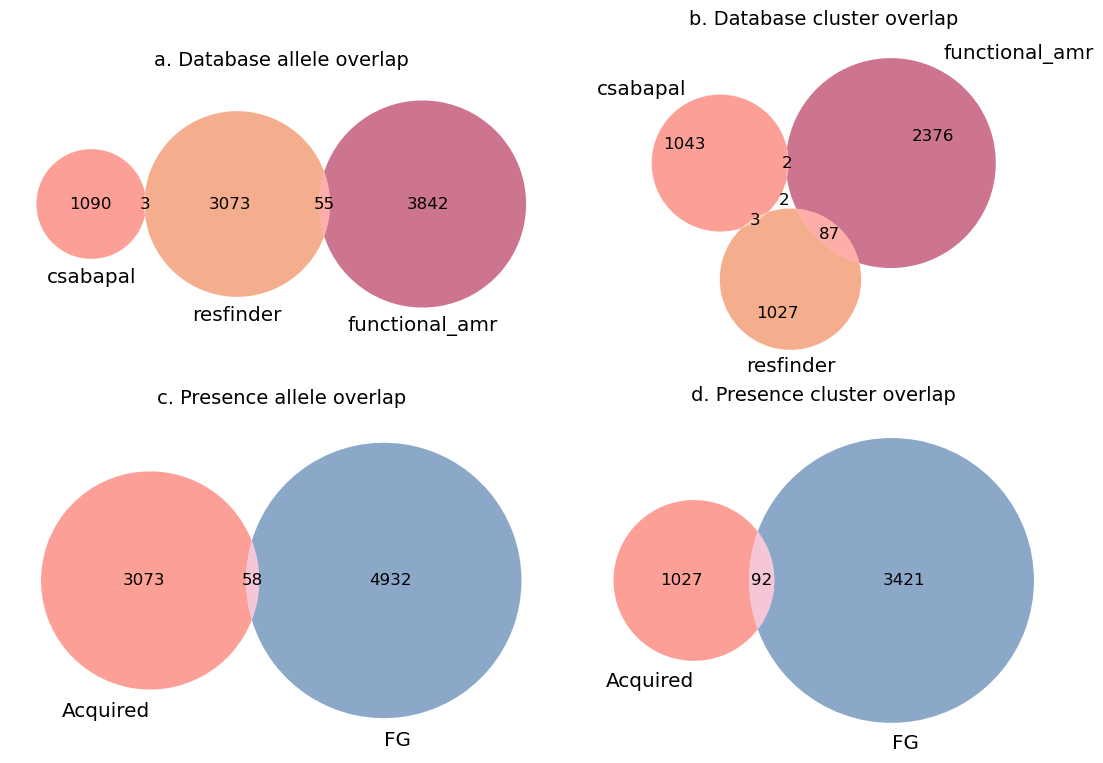

In [10]:
ncols = 2
nrows = 2
dim = 6

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(7*nrows, (7*ncols)/1.5), gridspec_kw={'wspace': 0, 'hspace': 0.1})
 
gene_db_alleles = sel_genesClusters.loc[
    sel_genesClusters.database.isin(['resfinder', 'csabapal', 'functional_amr'])
].reset_index().groupby(['database']).agg({'gene': 'unique'})['gene'].apply(set).to_dict()
gene_db_clusters = sel_genesClusters.loc[
    sel_genesClusters.database.isin(['resfinder', 'csabapal', 'functional_amr'])
].reset_index().groupby(['database']).agg({'cluster_representative_98': 'unique'})['cluster_representative_98'].apply(set).to_dict()


venn3(
    list(gene_db_alleles.values()), 
    set_labels=list(gene_db_alleles.keys()), 
    ax=axes[0,0],
    set_colors = list(db_palette.values()),
    alpha = .7
)
venn3(
    list(gene_db_clusters.values()),
    set_labels=list(gene_db_clusters.keys()), 
    ax=axes[0, 1],
    set_colors = list(db_palette.values()),
    alpha = .7
)


venn2(
    [
        set(sel_genesClusters.loc[sel_genesClusters.database.isin(['resfinder'])].reset_index()['gene']),
        set(sel_genesClusters.loc[sel_genesClusters.database.isin(['csabapal', 'functional_amr'])].reset_index()['gene'])

    ], 
    set_labels=['Acquired', 'FG'], 
    ax=axes[1,0],
    set_colors = list(dbgroup_palette2.values()),
    alpha = .7
)
venn2(
    [
        set(sel_genesClusters.loc[sel_genesClusters.database.isin(['resfinder'])].reset_index()['cluster_representative_98']),
        set(sel_genesClusters.loc[sel_genesClusters.database.isin(['csabapal', 'functional_amr'])].reset_index()['cluster_representative_98'])

    ], 
    set_labels=['Acquired', 'FG'], 
    ax=axes[1,1],
    set_colors = list(dbgroup_palette2.values()),
    alpha = .7
)


for (ax, letter, title) in zip(axes.flatten(), alphabet, ['Database allele overlap', 'Database cluster overlap', 'Presence allele overlap', 'Presence cluster overlap']):
    #ax.text(-0.05, 1.05, letter + '.', transform=ax.transAxes, fontsize=12, va='top', ha='right', fontweight='bold')
    ax.set_title(f"{letter}. {title}")

fig.tight_layout()
fig.savefig(os.path.join(fig_dir, 'overlap_databases.png'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'overlap_databases.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'overlap_databases.tiff'), bbox_inches='tight')

### Figure S3

/tmp/ipykernel_2349147/1896695174.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = sel_genesClusters.replace({'ResFinder': 'Acquired', 'Functional': 'FG'}).reset_index().explode('class').groupby(


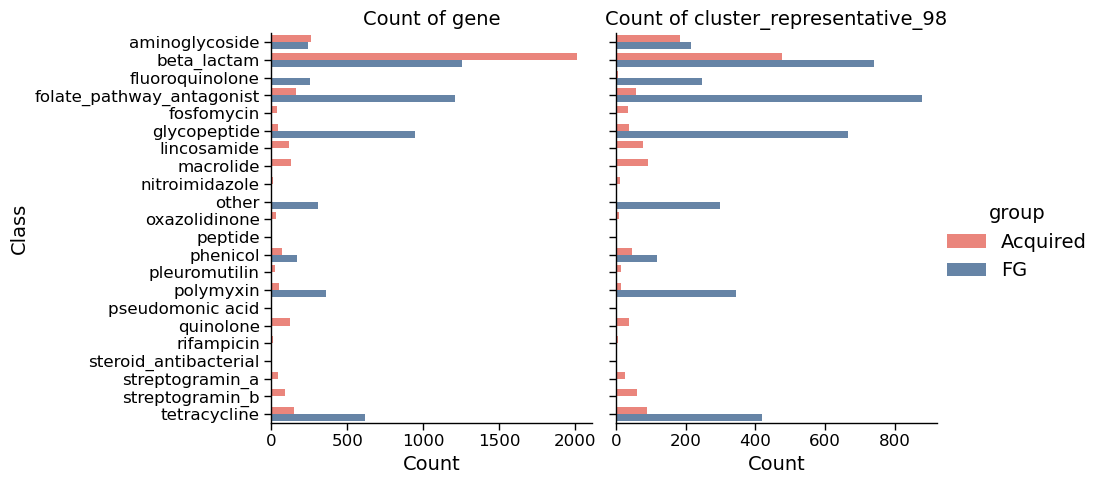

In [11]:
g_geneClasses = sns.catplot(
    data = sel_genesClusters.replace({'ResFinder': 'Acquired', 'Functional': 'FG'}).reset_index().explode('class').groupby(
        ['group', 'class']
    ).agg(
        {'gene': 'nunique', 'cluster_representative_98': 'nunique'})
    .reset_index().melt(id_vars=['group', 'class'], value_name='Count').rename(columns={'class': 'Class'}),
    x = 'Count',
    y = 'Class',
    hue = 'group',
    col = 'variable',
    kind = 'bar',
    palette = dbgroup_palette2,
    sharex=False
)
g_geneClasses.set_titles("Count of {col_name}")

g_geneClasses.fig.savefig(os.path.join(fig_dir, 'overlap_database_class.png'), bbox_inches='tight')
g_geneClasses.fig.savefig(os.path.join(fig_dir, 'overlap_database_class.pdf'), bbox_inches='tight')
g_geneClasses.fig.savefig(os.path.join(fig_dir, 'overlap_database_class.tiff'), bbox_inches='tight')

# Counts & Abundances

Contains code for:
* Descriptive statistics
* Figure S4
* Figure S6

In [12]:
# Load in counts of the ARGs
counts_clusters = pd.read_csv(os.path.join(data_dir, 'counts_clusters.csv'))
counts_clusters_meta = counts_clusters.reset_index().merge(metadata[['genepid', 'Region']].drop_duplicates(), on='genepid').drop_duplicates()
counts_rf = counts_clusters_meta.query("group == 'ResFinder'").pivot_table(index=['genepid', 'Region'], values='fragmentCountAln_adj_kb', columns='cluster_representative_98', fill_value=0)
counts_functional = counts_clusters_meta.query("group == 'Functional'").pivot_table(index=['genepid', 'Region'], values='fragmentCountAln_adj_kb', columns='cluster_representative_98', fill_value=0)


In [13]:
# Load in the genus counts
counts_genus = pd.read_csv('../motus_counts/motus_agg_pad/genus_motus_pad_agg_counts.csv')

# Get those taxa that are bacterial
genus_tax = pd.read_csv('../motus_counts/motus_agg_pad/genus_motus_pad_agg_taxa_paths.csv')
bacterial_taxa = genus_tax.loc[genus_tax['path_taxs'].str.startswith('2;'), 'name'].values.tolist()


counts_genus = counts_genus.merge(
    metadata[['genepid', 'city', 'country', 'Region']].drop_duplicates(), on='genepid', how='left'
).set_index(['genepid', 'city', 'country', 'Region'])

counts_genus = counts_genus.iloc[:, counts_genus.columns.isin(bacterial_taxa)]

In [14]:
# Load in kingdom counts
kingdom_counts = pd.read_csv('../motus_counts/motus_agg_pad/kingdom_motus_pad_agg.csv')


In [15]:
# Total read fragment counts
tot_counts = pd.read_csv(os.path.join(data_dir, 'tot_counts.csv'), index_col=0)
panres_counts = pd.read_csv(os.path.join(data_dir, 'panres_counts.csv'), index_col=0)

In [16]:
# only retain genera that makes up more than 0.0001% of all mOTU reads
# for ALR and beta-diversity
genus_retained = pd.DataFrame((counts_genus.replace([np.inf], np.nan).sum() / counts_genus.replace([np.inf], np.nan).sum().sum())*100, columns=['pct']).query("pct >= 0.0001").index
counts_genus_reduced = counts_genus[genus_retained]

## Descriptive

In [17]:
# Total counts
allSampleCounts = tot_counts.groupby(['name']).agg({'total_fragments': 'sum'}).merge(
    kingdom_counts.groupby(['run_accession']).agg({'fragmentCountAln': 'sum'}),
    left_index=True,
    right_index=True,
    how='left'
).merge(
    panres_counts.drop_duplicates().groupby(['sample_name']).agg({'fragmentCountAln': 'sum'}),
    left_index=True,
    right_index=True,
    how='left',
    suffixes=['_mOTU', '_PanRes']
).merge(
    counts_clusters.reset_index().groupby(['complete_name', 'group']).agg({'fragmentCountAln': 'sum'}).reset_index().pivot_table(index='complete_name', columns='group', values='fragmentCountAln'),
    left_index=True,
    right_index=True,
    how = 'left'
).merge(
    kingdom_counts.groupby(['run_accession', 'name']).agg({'fragmentCountAln': 'sum'}).reset_index().pivot_table(index='run_accession', columns='name', values='fragmentCountAln', fill_value=0),
    left_index=True,
    right_index=True,
    how = 'left'
)

allSampleCounts['could_be_aligned'] = allSampleCounts['fragmentCountAln_mOTU'] + allSampleCounts['fragmentCountAln_PanRes']

pd.concat(
    [
        allSampleCounts.sum(), 
        allSampleCounts.sum().apply(lambda x: x / allSampleCounts['total_fragments'].sum()*100)
    ], 
    keys=['reads', 'pct'],
    axis = 1
).round(6)

,reads,pct
total_fragments,8.881552e+10,100.000000
fragmentCountAln_mOTU,1.394357e+08,0.156995
fragmentCountAln_PanRes,1.037918e+08,0.116862
Functional,9.181689e+06,0.010338
ResFinder,6.513520e+06,0.007334
Archaea,7.850280e+05,0.000884
Bacteria,1.386483e+08,0.156108
Eukaryota,2.207000e+03,0.000002
Unknown cellular organism,1.860000e+02,0.000000
could_be_aligned,2.322767e+08,0.261527


In [18]:
# Percentage of mOTU per kingdom
print(
    (allSampleCounts[['fragmentCountAln_mOTU', 'Bacteria', 'Eukaryota', 'Archaea']].sum() / allSampleCounts['fragmentCountAln_mOTU'].sum())*100
)

fragmentCountAln_mOTU    100.000000
Bacteria                  99.435280
Eukaryota                  0.001583
Archaea                    0.563003
dtype: float64


In [19]:
# Top 5 genera
top5genera = pd.DataFrame(counts_genus.replace([-np.inf, np.inf], np.nan).dropna().sum().sort_values().tail(5))

top5genera['pct'] = (top5genera[0] /  (261.221350 * 10**(6))) * 100
top5genera

,0,pct
Streptococcus,2.269422e+06,0.868774
Neisseria,3.556523e+06,1.361498
Acidovorax,4.627822e+06,1.771609
Acinetobacter,6.366630e+06,2.437255
Pseudomonas,7.612052e+06,2.914024


In [20]:
# Million aligned of PanRes to FG or Acquired
allSampleCounts[['fragmentCountAln_PanRes', 'Functional', 'ResFinder']].sum() * 1e-6

fragmentCountAln_PanRes    103.791795
Functional                   9.181689
ResFinder                    6.513520
dtype: float64

In [21]:
# Summary statistics for PanRes
allSampleCounts[['fragmentCountAln_mOTU', 'fragmentCountAln_PanRes', 'Functional', 'ResFinder']].describe() * 10e-6

,fragmentCountAln_mOTU,fragmentCountAln_PanRes,Functional,ResFinder
count,0.013960,0.013010,0.005020,0.005020
mean,0.998823,0.797785,0.182902,0.129751
std,0.507809,0.643675,0.155851,0.140462
min,0.019800,0.011510,0.009430,0.002970
25%,0.687125,0.421410,0.097810,0.059530
50%,0.998290,0.689260,0.147275,0.094015
75%,1.277220,1.003390,0.222188,0.148560
max,6.067000,7.198810,1.615760,1.133460


In [22]:
# Unique number of references hit and percentages of them hit
foundClusters = sel_genesClusters[['cluster_representative_98', 'group']].drop_duplicates().merge(
    counts_clusters.reset_index().groupby(['group', 'cluster_representative_98']).agg({'fragmentCountAln': 'sum'}).reset_index(),
    on=['cluster_representative_98', 'group'],
    how='left'
)

print(
    foundClusters.groupby(['group']).agg({'cluster_representative_98': 'nunique'}),
    (
        foundClusters.dropna(subset='fragmentCountAln').groupby(['group']).agg({'cluster_representative_98': 'nunique'}) / foundClusters.groupby(['group']).agg({'cluster_representative_98': 'nunique'})*100), 
    sep='\n'
)

            cluster_representative_98
group                                
Functional                       3497
ResFinder                        1119
            cluster_representative_98
group                                
Functional                  88.504432
ResFinder                   94.012511


In [23]:
# Unique number of references HIT.
foundClusters.dropna(subset='fragmentCountAln').groupby(['group']).agg({'cluster_representative_98': 'nunique'})

,cluster_representative_98
group,
Functional,3095
ResFinder,1052


## Alpha-diversities

In [24]:
# What to name the three groups
alpha_keys =  ['Acquired', 'FG', 'Genera']

In [25]:
# Calculate the total fragments per sample
total_frags = pd.concat(
    [
        pd.DataFrame(counts_rf.sum(1), columns=['Total_frag']).reset_index(),
        pd.DataFrame(counts_functional.sum(1), columns=['Total_frag']).reset_index(),
        pd.DataFrame(counts_genus.sum(1), columns=['Total_frag']).reset_index()#.rename(columns={'genepid': 'sample_name'}),
    ],
    keys = alpha_keys
).reset_index().pivot_table(
    index='genepid', columns='level_0', values='Total_frag'
).melt(
    ignore_index=False, id_vars='Genera', value_name='ARG'
)

In [26]:
# Estimate richness
richness = pd.concat(
    [
        estimate_richness(counts_rf.melt(ignore_index=False, var_name='gene', value_name='fragmentCountAln_adj').reset_index(), groupby='genepid'),
        estimate_richness(counts_functional.melt(ignore_index=False, var_name='gene', value_name='fragmentCountAln_adj').reset_index(), groupby='genepid'),
        estimate_richness(counts_genus.melt(ignore_index=False, var_name='gene', value_name='fragmentCountAln_adj').reset_index(), groupby='genepid'),
    ],
    keys =alpha_keys
).reset_index().pivot_table(
    index='genepid', columns='level_0', values='n_references'
).melt(
    ignore_index=False, id_vars='Genera', value_name='ARG'
)

In [27]:
# Estimate shannon
shannon = pd.concat(
    [
        estimate_shannon(counts_rf.melt(ignore_index=False, var_name='gene', value_name='fragmentCountAln_adj').reset_index(), groupby=['genepid', 'gene']),
        estimate_shannon(counts_functional.melt(ignore_index=False, var_name='gene', value_name='fragmentCountAln_adj').reset_index(), groupby=['genepid', 'gene']),
        estimate_shannon(counts_genus.melt(ignore_index=False, var_name='gene', value_name='fragmentCountAln_adj').reset_index(), groupby=['genepid', 'gene']),
    ],
    keys = alpha_keys
).reset_index().pivot_table(
    index='genepid', columns='level_0', values='shannon'
).melt(
    ignore_index=False, id_vars='Genera', value_name='ARG'
)

/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Figure S4

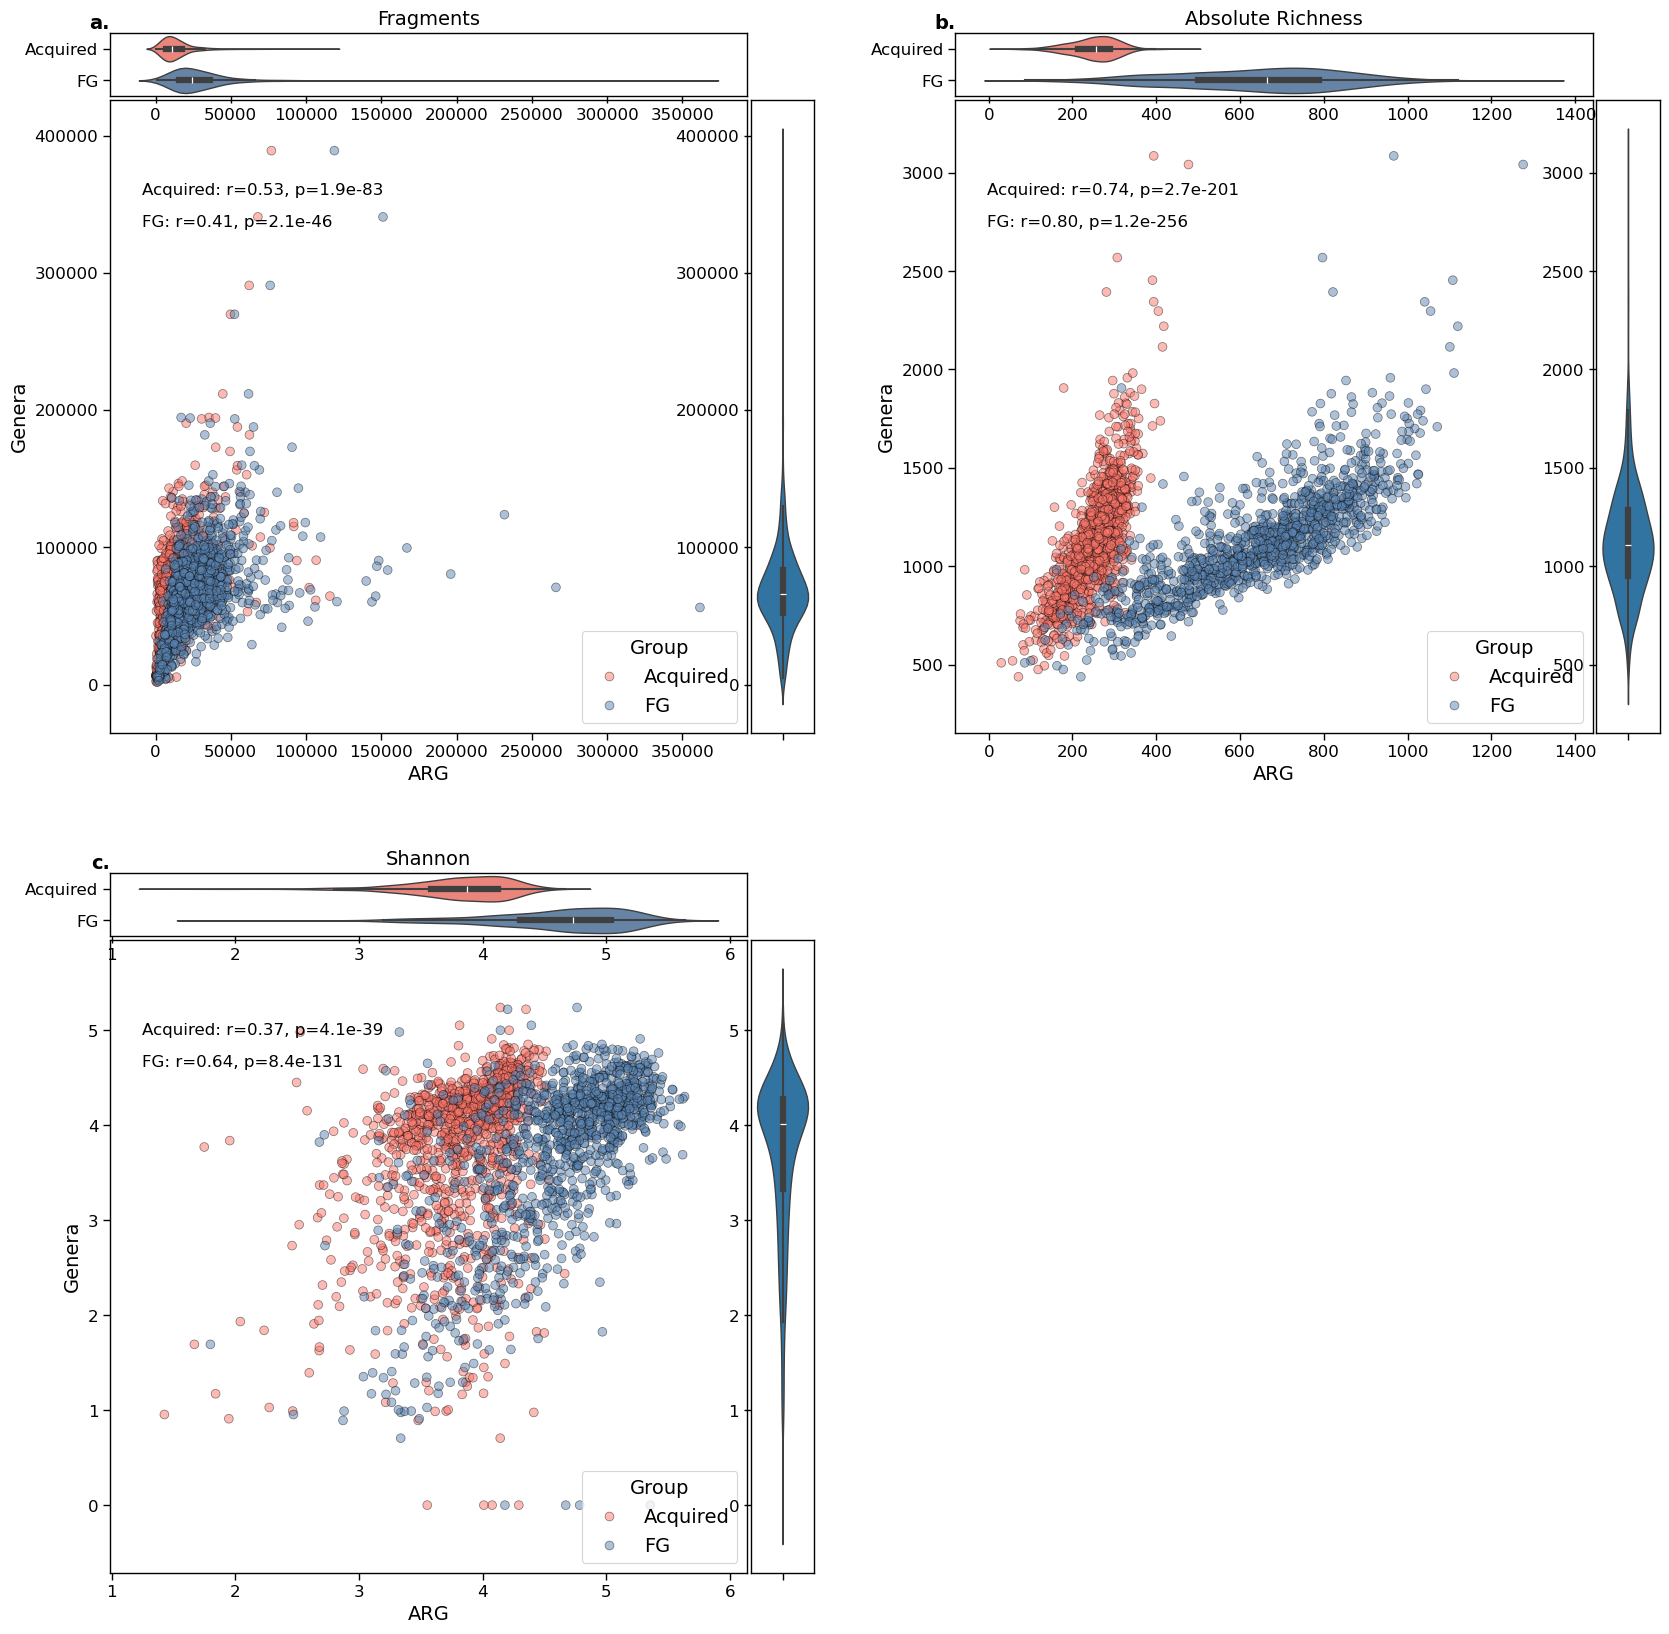

In [129]:
def annotate(data, **kws):
    r, p = ss.pearsonr(data[kws['x']], data[kws['y']])
    ax = kws.get('ax', plt.gca())

    x = 0.05 + kws.get('x_scatter', 0)
    y = 0.8 + kws.get('y_scatter', 0)
    ax.text(x, y, '{} r={:.2f}, p={:.2g}'.format(kws.get('label', ''), r, p), transform=ax.transAxes)

x = 'ARG'
y = 'Genera'

fig = plt.figure(figsize=(20,20))

gs = gridspec.GridSpec(ncols=2, nrows=2)

idxs = [[0,0], [0,1], [1,0], [1,1]]

for idx, div_df, title, letter in zip(idxs, [total_frags, richness, shannon], ['Fragments','Absolute Richness', 'Shannon'], alphabet):

    div_df = div_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    gs_sub = gridspec.GridSpecFromSubplotSpec(
        ncols=2, nrows=2, 
        width_ratios=[1, .1], 
        height_ratios=[.1, 1], 
        hspace=0.01, wspace=0.01,
        subplot_spec=gs[*idx]
    )

    ax_main = fig.add_subplot(gs_sub[1, 0])
    ax_top = fig.add_subplot(gs_sub[0,0], sharex=ax_main)
    ax_right = fig.add_subplot(gs_sub[1, 1], sharey=ax_main)

    ax_top.set_title(title)


    sns.violinplot(
        data = div_df.reset_index(),
        x = x,
        y = 'level_0',
        hue = 'level_0',
        ax = ax_top,
        palette = dbgroup_palette2
    )
    
    sns.violinplot(
        data = div_df.reset_index()[['genepid', 'Genera']].drop_duplicates(),
        y = y,
        ax = ax_right,
    )
    
    sns.scatterplot(
        data = div_df.reset_index(),#.query("level_0 == 'Mobilized'"),
        y = y,
        x = x,
        hue = 'level_0',
        ax = ax_main,
        palette = dbgroup_palette2,
        alpha = .5,
        edgecolor='black',
        s=marker_size
    )

    annotate(
        div_df.query("level_0 == 'FG'").dropna(),
        ax = ax_main,
        x = x,
        y = y,
        label = 'FG' + ':'
    )

    annotate(
        div_df.query("level_0 == 'Acquired'").dropna(),
        ax = ax_main,
        x = x,
        y = y,
        label = 'Acquired' + ':',
        y_scatter = 0.05
    )

    ax_top.set_xlabel('')
    ax_top.set_ylabel('')
    ax_right.set_ylabel('')
    ax_main.set_xlabel('ARG')

    ax_main.legend(loc='lower right', title='Group')

    ax_top.text(-0.0, 1.3, letter + '.', transform=ax_top.transAxes, fontsize=axis_title_fontsize, va='top', ha='right', fontweight='bold')

fig.savefig(os.path.join(fig_dir, 'diversities_all.png'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'diversities_all.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'diversities_all.tiff'), bbox_inches='tight')

## Pan- and core-resistomes

In [ ]:
all_classes = sel_genesClusters.replace({'ResFinder': 'Acquired', 'Functional': 'FG'}).reset_index().explode('class')[['group', 'class']].drop_duplicates().dropna()

overlapping_classes = pd.DataFrame(all_classes['class'].unique(), columns=['class'])
overlapping_classes['Acquired'] = overlapping_classes['class'].isin(all_classes.loc[all_classes['group'] == 'Acquired', 'class'])
overlapping_classes['FG'] = overlapping_classes['class'].isin(all_classes.loc[all_classes['group'] == 'FG', 'class'])

overlapping_classes_list = sorted(overlapping_classes.query("Acquired == True & FG == True")['class'].values.tolist())
overlapping_classes_list.pop(overlapping_classes_list.index('other'))
print(overlapping_classes_list)

class_subsets = overlapping_classes_list
class_palette, class_handles = make_palette(
    labels=class_subsets,
    colors=['#540d6e', '#a1286a', '#ee4266', '#f78a53', '#ffd23f', '#9dd076', '#3bceac', '#25be8b', '#0ead69', '#1f7a8c']
)


In [ ]:
counts_rf2 = counts_rf.copy()
counts_rf2['group'] = 'Acquired'
counts_functional2 = counts_functional.copy()
counts_functional2['group'] = 'FG'
counts_combined = pd.concat([counts_rf2.set_index('group', append=True), counts_functional2.set_index('group', append=True)]).fillna(0)
counts_combined2 = counts_combined.melt(ignore_index=False).reset_index().merge(
    sel_genesClusters[['cluster_representative_98', 'class']].explode('class').drop_duplicates(), on='cluster_representative_98', how='left'
).drop_duplicates()
counts_combined2.loc[~ (counts_combined2['class'].isin(class_subsets)), 'class'] = 'other'

In [ ]:
genomes = sel_genesClusters.reset_index()[['cluster_representative_98', 'class', 'group']].explode('class').drop_duplicates()


In [ ]:
global_pan_genome = counts_combined2.query("value > 0").groupby(['group', 'cluster_representative_98']).agg({'genepid': 'nunique'}).reset_index()
global_pan_genome['Region'] = 'Global'
genomes.set_index(['group', 'class', 'cluster_representative_98']).merge(
    global_pan_genome.pivot_table(
        index=['cluster_representative_98', 'group'],
        columns='Region',
        values = 'genepid',
        fill_value=0
    ),
    left_index=True,
    right_index=True,
    how='left'
).fillna(0)

In [ ]:
#pan_genomes.loc[pan_genomes['class'].isin(class_subsets), 'class'] = 'other'
genomes['group'] = genomes['group'].map({'ResFinder': 'Acquired', 'Functional': 'FG'})
#pan_genomes[list(region_palette.keys())] = 0
genomes = genomes.loc[genomes['class'] != 'other']

class_references = genomes.groupby(['group', 'class']).agg({'cluster_representative_98': 'nunique'})

pan_genomes_counts = genomes.set_index(['group', 'class', 'cluster_representative_98']).merge(
    counts_combined2.query("value > 0").groupby(['group', 'Region', 'cluster_representative_98']).agg({'genepid': 'nunique'}).reset_index().pivot_table(
        index=['cluster_representative_98', 'group'],
        columns='Region',
        values = 'genepid',
        fill_value=0
    ), 
    left_index=True,
    right_index=True,
    how='left'
).fillna(0)

pan_genomes = (pan_genomes_counts > 0).melt(
    ignore_index=False
).reset_index(
).groupby(
    ['group','class', 'variable', 'value']
).agg({'cluster_representative_98': 'nunique'}).merge(
    class_references, 
    left_index=True,
    right_index=True,
    suffixes=['_count', '_ref']
)



In [ ]:
sampleRegionCounts = metadata.groupby('Region').agg({'genepid': 'nunique'})

core_genome_frequencies = pan_genomes_counts.apply(lambda x: [v / sampleRegionCounts.loc[i, 'genepid'] for v, i in zip(x.values, x.index.values)] , axis = 1, result_type='expand')
core_genome_frequencies.columns = pan_genomes_counts.columns

In [ ]:
counts_combined_passed = counts_combined2.merge(
    (core_genome_frequencies >= 0.5).melt(ignore_index=False, var_name='Region', value_name='passed_freq').reset_index(),
    on=['group', 'Region', 'cluster_representative_98', 'class']
).query("value > 0 & passed_freq == True" ).groupby(['group', 'Region', 'cluster_representative_98']).agg({'genepid': 'nunique'}).reset_index().pivot_table(
        index=['cluster_representative_98', 'group'],
        columns='Region',
        values = 'genepid',
        fill_value=0
    )

core_genomes_counts = genomes.set_index(['group', 'class', 'cluster_representative_98']).merge(
    counts_combined_passed, 
    left_index=True,
    right_index=True,
    how='left'
).fillna(0)

In [ ]:
core_genomes = (core_genomes_counts > 0).melt(
    ignore_index=False
).reset_index(
).groupby(
    ['group','class', 'variable', 'value']
).agg({'cluster_representative_98': 'nunique'}).merge(
    class_references, 
    left_index=True,
    right_index=True,
    suffixes=['_count', '_ref']
)

### Figure S6

In [ ]:
fig = plt.figure(figsize=(13,10))
#, axes = plt.subplots(ncols = 2, nrows = 1, sharey=True, sharex=False, figsize=(13,5), gridspec_kw={'wspace': .7})
gs = gridspec.GridSpec(ncols=2, nrows=2, wspace=.7, figure=fig, hspace=.1)
ax_pan_rf = fig.add_subplot(gs[0,0])
ax_pan_fg = fig.add_subplot(gs[1,0])
ax_core_rf = fig.add_subplot(gs[0, 1], sharey=ax_pan_rf)
ax_core_fg = fig.add_subplot(gs[1, 1], sharey=ax_pan_fg)

for i, l in enumerate(['Acquired', 'FG']):
    if i == 0:
        ax_pan = ax_pan_rf
        ax_core = ax_core_rf
    else:
        ax_pan = ax_pan_fg
        ax_core = ax_core_fg

    ax_pan.set_ylabel(l)

    pivoted_pan_genomes = pan_genomes.xs(
        l, level='group'
    ).reset_index(
    ).query("value == True").pivot_table(
        index='variable', columns='class', values = 'cluster_representative_98_count'
    )
    pivoted_pan_genomes.iloc[:, np.where(pivoted_pan_genomes.columns.isin(class_subsets))[0]].plot.barh(
        stacked=True, 
        color=class_palette,
        ax=ax_pan
    )

    pivoted_core_genomes = core_genomes.xs(
        l, level='group'
    ).reset_index(
    ).query("value == True").pivot_table(
        index='variable', columns='class', values = 'cluster_representative_98_count'
    )
    pivoted_core_genomes.iloc[:, np.where(pivoted_core_genomes.columns.isin(class_subsets))[0]].plot.barh(
        stacked=True, 
        color=class_palette,
        ax=ax_core
    )

    ax_pan.get_legend().remove()
    ax_core.get_legend().remove()

    ax_pan.yaxis.tick_right()
    ax_pan.invert_xaxis()

    ax_pan.set_ylabel(l)

    for tick in ax_pan.yaxis.get_majorticklabels():
        tick.set_horizontalalignment('center')
        tick.set_position((1.31, 0))


ax_pan_fg.legend(handles=class_handles, ncol = 3, loc='lower right', bbox_to_anchor=(2.4,-.45))

ax_pan_rf.set_title('Pan-resistome')
ax_core_rf.set_title('Core-resistome')

fig.savefig(os.path.join(fig_dir, 'core_pan_resistome.png'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'core_pan_resistome.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'core_pan_resistome.tiff'), bbox_inches='tight')

## ALR Abundances

In [ ]:
# First, estimate the fragment sums per sample
sampleSums = counts_clusters.reset_index().drop_duplicates().groupby(
    ['group', 'genepid']
).agg(
    {'fragmentCountAln_adj_kb': 'sum'}
).reset_index().merge(
    counts_genus_reduced.drop_duplicates().sum(1).reset_index().rename(columns={0:'fragmentCountAln_bac'}).drop(columns=['Region']), 
    on='genepid'
)

sampleSumsMeta = sampleSums.drop_duplicates()
sampleSumsMeta['fragmentCountAln_bac'] /= 1e6

In [ ]:
# Estimate ALR abundances per country
countryALR = sampleSumsMeta.groupby(
    ['country', 'group']
).agg(
    {'fragmentCountAln_bac': 'sum', 'fragmentCountAln_adj_kb': 'sum'}
).apply(lambda x: np.log10(x['fragmentCountAln_adj_kb'] / x['fragmentCountAln_bac']), axis=1)


countryALR = pd.DataFrame(countryALR, columns=['ALR'])
countryALR = countryALR.reset_index().merge(
    geo_data[['country', 'country_geometry']].drop_duplicates().replace(
        {
            'United States': 'United States of America',
            'Bosnia and Herzegovina': 'Bosnia and Herz.',
            'Democratic Republic of the Congo': 'Dem. Rep. Congo',
            'Czech Republic': 'Czechia',
            'Ivory Coast' :"Côte d'Ivoire",
            'Macedonia': 'North Macedonia',
            
        }
    ), 
    on='country', how='left'
).drop_duplicates()

countryALR.loc[
    countryALR.country == 'Malaysia', 'country_geometry'
] = geo_data.query("country == 'Malaysia'")["country_geometry"].drop_duplicates().dropna().item()

countryALR = gpd.GeoDataFrame(countryALR, geometry='country_geometry')

### Figure S5

In [ ]:
alr_vmin = countryALR['ALR'].min()
alr_vmax = countryALR['ALR'].max()

cmap = 'magma_r'

dim = 10
scale = 1.5

fig = plt.figure(figsize=((dim*scale)*nrows,dim*ncols))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, wspace=0.05, hspace=-0.15)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=alr_vmin, vmax=alr_vmax))
cbar_label = 'ALR Abundance'

title2query = {'ResFinder': 1, 'Functional': 0}
title2title = {'ResFinder': 'Acquired', 'Functional': 'FG'}
for i, (df, axtitle, k) in enumerate(zip([counts_rf, counts_functional], ['ResFinder', 'Functional'], [5, 5])):   
    
    gs_sub = gridspec.GridSpecFromSubplotSpec(
        nrows = 3, ncols = 2,
        subplot_spec = gs[i],
        width_ratios = [1, 0.025],
        height_ratios = [.25, .5, .25],
        wspace = -.05,

    )
    ax_map = fig.add_subplot(gs_sub[:, 0])
    ax_map.set_title(title2title[axtitle])

    countries.plot(color='white', edgecolor='lightgray', hatch='///', alpha = .5, ax=ax_map)
    countryALR.loc[
        countryALR.group == axtitle
    ].plot(
        column='ALR',
        cmap = cmap,
        scheme="natural_breaks",
        legend=True,
        legend_kwds={
            'title': cbar_label, 
        },
        ax = ax_map,
        k = k
    )
    
    ax_map.axis('off')

fig.savefig(os.path.join(fig_dir, 'map_abns.png'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'map_abns.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'map_abns.tiff'), bbox_inches='tight')

## Beta-diversities

In [ ]:
counts_resfinder = counts_rf.copy()
#counts_resfinder.index.names = ['bindCol', 'Region']
counts_functional_amr = counts_clusters_meta.loc[(counts_clusters_meta.resfinder == False) & (counts_clusters_meta.functional_amr == True)].pivot_table(index=['genepid', 'Region'], columns='cluster_representative_98', values='fragmentCountAln_adj_kb', fill_value=0, aggfunc='sum')
counts_csabapal = counts_clusters_meta.loc[(counts_clusters_meta.resfinder == False) & (counts_clusters_meta.functional_amr == False) & (counts_clusters_meta.csabapal == True)].pivot_table(index=['genepid', 'Region'], columns='cluster_representative_98', values='fragmentCountAln_adj_kb', fill_value=0, aggfunc='sum')

scoresDict = {}

### Figure 1

In [ ]:
regionAbbrs = {
    'East Asia & Pacific': 'EAP',
    'Europe & Central Asia': 'ECA',
    'Latin America & Caribbean': 'LAC',
    'Middle East & North Africa': 'MENA',
    'North America': 'NA',
    'Sub-Saharan Africa': 'SSA',
    'South Asia': 'SA'
}

region_handles2

countryALRRegions = countryALR.merge(metadata[['Region', 'country']].drop_duplicates(), on='country')#.pivot_table(index=['country', 'Region'], columns='group', values='ALR')
widths = metadata[['Region', 'country']].drop_duplicates().groupby('Region').agg({'country': 'nunique'})['country']
widths /= widths.sum()
min_width = 0.025
widths[np.where(widths < min_width)[0]] = min_width

ymin = countryALRRegions['ALR'].min() - 0.1
ymax = countryALRRegions['ALR'].max() + 0.1

fig = plt.figure(figsize=(20,13))
gs = gridspec.GridSpec(
    nrows=2, ncols=len(region_order), 
    wspace = 0.001,
    width_ratios=widths,
    hspace = 0.5,
    figure=fig,
    height_ratios = [0.3, 0.6]
)

xlim_adj = 0.5
ax=None

for i, region in enumerate(region_order): #zip(axes[0,].flatten(), region_order):
    ax = fig.add_subplot(gs[0,i])
    ax.set_title(regionAbbrs[region])

    m = countryALRRegions.loc[countryALRRegions.Region == region,]
    m.query("group == 'ResFinder'").replace({'ResFinder': 'Acquired'}).plot.scatter(y='ALR', x='country', color=dbgroup_palette['ResFinder'], ax = ax, s = marker_size, edgecolors='black')
    m.query("group == 'Functional'").replace({'Functional': 'FG'}).plot.scatter(y='ALR', x='country', color=dbgroup_palette['Functional'], ax=ax, s = marker_size, edgecolors='black')
    ax.tick_params(axis="x", labelrotation=90, which="major")
    #ax.tick_params(axis='x', which='major', pad=15)
    ax.set_ylim(ymin, ymax)

    if m.shape[0] <= 12:
        xlims = ax.get_xlim()
        ax.set_xlim(xlims[0]-xlim_adj, xlims[1]+xlim_adj)
    
    ax.set_xlabel("")

    if i > 0:
        ax.get_yaxis().set_visible(False)
    else:
        ax.text(-0.05, 1.05, 'a.', transform=ax.transAxes, fontsize=axis_title_fontsize, va='top', ha='right', fontweight='bold')

ax.legend(loc='lower right', handles = dbgroup_handles2[:-1])


gs_pca = gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[1,:],
    ncols=2,
    nrows = 1
)

for i, (df, axtitle) in enumerate(zip([counts_rf, counts_functional], ['Acquired', 'FG'])):
    ax_biplot = fig.add_subplot(gs_pca[i])
    ax_biplot.set_title(axtitle)

    plot_data = df.reset_index()
    data = df.reset_index(drop=True)

    pcaObj = pycodamath.pca.Biplot(
       data = data,
       default = False,
       axis = ax_biplot
    )

    #pcaObj.plotscores(group=plot_data['Region'], palette=region_palette)
    pcaObj.plotellipses(group=plot_data['Region'], palette=region_palette)

    scoresDF = pcaObj.scores.T.merge(plot_data[['genepid', 'Region']], left_index=True, right_index=True)
    scoresDict[axtitle] =  scoresDF

    sns.scatterplot(
        data = scoresDF,
        x = 'pc1',
        y = 'pc2',
        hue = 'Region',
        s=30,
        edgecolor='black',
        alpha = .9,
        ax = ax_biplot,
        legend = False,
        palette=region_palette
    )


    if i == 0:
        ax_biplot.text(-0.05, 1.05, 'b.', transform=ax_biplot.transAxes, fontsize=axis_title_fontsize, va='top', ha='right', fontweight='bold')
        ax_biplot.legend(handles=region_handles2, loc='lower center', ncols=3, bbox_to_anchor=(1,-.3), title='Region')

fig.savefig(os.path.join(fig_dir, 'fig1_country_alrs_biplot.png'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'fig1_country_alrs_biplot.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'fig1_country_alrs_biplot.tiff'), bbox_inches='tight')

### Figure S7

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
for ax, df, axtitle in zip(axes.flatten(), [counts_resfinder, counts_functional_amr, counts_csabapal, counts_genus_reduced], ['resfinder', 'functional_amr', 'csabapal', 'Genera']):
    print(axtitle)
    ax.set_title(axtitle)

    plot_data = df.reset_index()
    data = df.reset_index(drop=True)

    pcaObj = pycodamath.pca.Biplot(
        data = data,
        default = False,
        axis = ax
    )

    #pcaObj.plotscores(group=plot_data['Region'], palette=region_palette)
    pcaObj.plotellipses(group=plot_data['Region'], palette=region_palette)

    scoresDF = pcaObj.scores.T.merge(plot_data[['genepid', 'Region']], left_index=True, right_index=True)
    scoresDict[axtitle] =  scoresDF
    
    sns.scatterplot(
        data = scoresDF,
        x = 'pc1',
        y = 'pc2',
        hue = 'Region',
        s=30,
        edgecolor='black',
        alpha = .9,
        ax = ax,
        legend = False,
        palette=region_palette
    )

axes[1,0].legend(handles=region_handles, loc='lower center', ncols=2, bbox_to_anchor=(1,-.6), title='Region')

fig.savefig(os.path.join(fig_dir, 'pca_db_region_collection.png'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'pca_db_region_collection.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(fig_dir, 'pca_db_region_collection.tiff'), bbox_inches='tight')

### Procrustes

In [51]:
scoreFiles = []
for k, v in scoresDict.items():
    print(k, v.columns)
    scoreFile=os.path.join(data_dir, f"pca_scores_{k.lower()}.csv")
    v.rename(columns={'genepid':'bindCol'}).to_csv(scoreFile, index=None)
    scoreFiles.append(scoreFile)

Acquired Index(['pc1', 'pc2', 'genepid', 'Region'], dtype='object')
FG Index(['pc1', 'pc2', 'genepid', 'Region'], dtype='object')
resfinder Index(['pc1', 'pc2', 'genepid', 'Region'], dtype='object')
functional_amr Index(['pc1', 'pc2', 'genepid', 'Region'], dtype='object')
csabapal Index(['pc1', 'pc2', 'genepid', 'Region'], dtype='object')
Genera Index(['pc1', 'pc2', 'genepid', 'Region'], dtype='object')


In [52]:
cmd_template = "../src/run_procrustes.r {} {}"

p_procrustes = re.compile(r"(\d+\.\d+)")
procrustesResults = []

df1 = '../data/pca_scores_genera.csv'

for df2 in set(scoreFiles):
    print(df1, df2)
    if df1 != df2:
        p = subprocess.run(cmd_template.format(df1, df2), shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if p.returncode == 0:
            m = p_procrustes.findall(p.stdout.decode())
            procrustesResults.append([os.path.basename(df1), os.path.basename(df2)] + m)

procrustesResults = pd.DataFrame(
    procrustesResults, 
    columns = ['df1', 'df2', 'Procrustes Sum of Squares', 'Correlation in a symmetric Procrustes rotation', 'Significance']
)

procrustesResults['df1'] = procrustesResults['df1'].str.extract(r"pca_scores_(\w+)\.csv")
procrustesResults['df2'] = procrustesResults['df2'].str.extract(r"pca_scores_(\w+)\.csv")

../data/pca_scores_genera.csv ../data/pca_scores_csabapal.csv
../data/pca_scores_genera.csv ../data/pca_scores_genera.csv
../data/pca_scores_genera.csv ../data/pca_scores_functional_amr.csv
../data/pca_scores_genera.csv ../data/pca_scores_fg.csv
../data/pca_scores_genera.csv ../data/pca_scores_resfinder.csv
../data/pca_scores_genera.csv ../data/pca_scores_acquired.csv


In [53]:
procrustesResults

,df1,df2,Procrustes Sum of Squares,Correlation in a symmetric Procrustes rotation,Significance
0,genera,csabapal,0.6204,0.6161,0.001
1,genera,functional_amr,0.4138,0.7656,0.001
2,genera,fg,0.5277,0.6872,0.001
3,genera,resfinder,0.2154,0.8858,0.001
4,genera,acquired,0.2154,0.8858,0.001


### Permanova with adonis2

In [59]:
clusters_meta_class = sel_genesClusters.reset_index().explode('class').drop_duplicates(['gene', 'cluster_representative_98', 'class', 'fa_name'])

clrFiles = []

for cg, cgdata in clusters_meta_class.groupby(['group', 'class']):
    if cg[0] == 'Functional':
        sel_counts = counts_functional.iloc[:, np.where(counts_functional.columns.isin(cgdata['cluster_representative_98'].unique()))[0]]
    else:
        sel_counts = counts_rf.iloc[:, np.where(counts_rf.columns.isin(cgdata['cluster_representative_98'].unique()))[0]]

    clrFile = os.path.join(data_dir, f"counts_{cg[0].lower()}_{cg[1]}_clr.csv")
    sel_counts.loc[:, (sel_counts!=0).any(axis=0)].coda.clr().to_csv(clrFile)
    print(clrFile)
    clrFiles.append(clrFile)

counts_rf.coda.clr().to_csv(os.path.join(data_dir, 'counts_resfinder_all_clr.csv'))
clrFiles.append(os.path.join(data_dir, 'counts_resfinder_all_clr.csv'))

counts_functional.coda.clr().to_csv(os.path.join(data_dir, 'counts_functional_all_clr.csv'))
clrFiles.append(os.path.join(data_dir, 'counts_functional_all_clr.csv'))

Dataframe contains zeros. Using Bayesian inference to replace zeros.
../data/counts_functional_aminoglycoside_clr.csv
Dataframe contains zeros. Using Bayesian inference to replace zeros.
../data/counts_functional_beta_lactam_clr.csv
Dataframe contains zeros. Using Bayesian inference to replace zeros.
../data/counts_functional_fluoroquinolone_clr.csv
Dataframe contains zeros. Using Bayesian inference to replace zeros.
../data/counts_functional_folate_pathway_antagonist_clr.csv
Dataframe contains zeros. Using Bayesian inference to replace zeros.
../data/counts_functional_glycopeptide_clr.csv
Dataframe contains zeros. Using Bayesian inference to replace zeros.
../data/counts_functional_macrolide_clr.csv
Dataframe contains zeros. Using Bayesian inference to replace zeros.
../data/counts_functional_other_clr.csv
Dataframe contains zeros. Using Bayesian inference to replace zeros.
../data/counts_functional_phenicol_clr.csv
Dataframe contains zeros. Using Bayesian inference to replace zeros.


In [61]:
import glob
import subprocess
adonis2Results = {}

cmd_template = "../src/run_adonis2.r {} {}"

#clrFiles = [os.path.join(data_dir, 'counts_functional_all_clr.csv'), os.path.join(data_dir, 'counts_resfinder_all_clr.csv')]

#clrRFFiles = glob.glob(os.path.join(data_dir, 'counts_resfinder*_clr.csv'))
#clrFuncFiles = glob.glob(os.path.join(data_dir, 'counts_functional*_clr.csv'))

#clrFiles = clrFiles + clrRFFiles + clrFuncFiles

for i, clrFile in enumerate(clrFiles):
    print(f" {i+1} / {len(clrFiles)}", end="\r")
    p = subprocess.run(cmd_template.format(clrFile, 'genepid'), shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    try:
        adonisRes = pd.read_csv(p.stdout.decode().strip().split(' ')[-1].replace('"', ''))
    except: 
        print(p.stderr.decode())
        continue

    dKey = os.path.basename(clrFile).replace('.csv', '').replace('counts_', '')
    adonis2Results[dKey] = adonisRes 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4
Error in file(file, "rt") : cannot open the connection
Calls: read.csv -> read.table -> file
In addition: Warning message:
In file(file, "rt") :
  cannot open file '../data/counts_resfinder_pseudomonic': No such file or directory
Execution halted



In [62]:
adonis2ResultsDF = pd.concat(list(adonis2Results.values()), keys=list(adonis2Results.keys())).reset_index()
adonis2ResultsDF[['group', 'class']] = adonis2ResultsDF.level_0.str.replace('_clr', '').str.extract(r"(resfinder|functional)(?:_(.+))?")
adonis2ResultsDF = adonis2ResultsDF.dropna(subset='group').dropna(subset='class')

adonis2ResultsDF['R2_label'] = adonis2ResultsDF.apply(lambda x: f"{x['R2']:.3f} (p = {x['Pr(>F)']})", axis=1)
adonis2ResultsDF.dropna(subset='F').pivot(index='class', columns='group', values=['R2_label', 'R2', 'Pr(>F)']).fillna('')

/tmp/ipykernel_2349147/3132988262.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adonis2ResultsDF.dropna(subset='F').pivot(index='class', columns='group', values=['R2_label', 'R2', 'Pr(>F)']).fillna('')


R2_label                            R2  \
group                             functional          resfinder functional   
class                                                                        
all                        0.074 (p = 0.001)  0.120 (p = 0.001)   0.074302   
aminoglycoside             0.047 (p = 0.001)  0.121 (p = 0.001)   0.047246   
beta_lactam                0.082 (p = 0.001)  0.116 (p = 0.001)   0.082174   
fluoroquinolone            0.069 (p = 0.001)  0.053 (p = 0.001)   0.068652   
folate_pathway_antagonist  0.060 (p = 0.001)  0.167 (p = 0.001)   0.059689   
fosfomycin                                    0.072 (p = 0.001)              
glycopeptide               0.078 (p = 0.001)  0.026 (p = 0.001)   0.078433   
lincosamide                                   0.087 (p = 0.001)              
macrolide                                     0.093 (p = 0.001)              
nitroimidazole                                0.144 (p = 0.001)              
other                      0.069 (p = 0.001)  0.049 (p = 0.001)   0.069299   
oxazolidinone                                 0.111 (p = 0.001)              
phenicol                   0.072 (p = 0.001)  0.138 (p = 0.001)   0.072052   
pleuromutilin                                 0.093 (p = 0.001)              
polymyxin                  0.067 (p = 0.001)  0.074 (p = 0.001)   0.067229   
quinolone                                     0.106 (p = 0.001)              
rifampicin                                    0.163 (p = 0.001)              
steroid_antibacterial                         0.003 (p = 0.752)              
streptogramin_a                               0.071 (p = 0.001)              
streptogramin_b                               0.083 (p = 0.001)              
tetracycline               0.073 (p = 0.001)  0.110 (p = 0.001)   0.072765   

                                        Pr(>F)            
group                     resfinder functional resfinder  
class                                                     
all                        0.119935      0.001     0.001  
aminoglycoside             0.120560      0.001     0.001  
beta_lactam                0.116472      0.001     0.001  
fluoroquinolone            0.052849      0.001     0.001  
folate_pathway_antagonist  0.167464      0.001     0.001  
fosfomycin                 0.071774                0.001  
glycopeptide               0.026239      0.001     0.001  
lincosamide                0.087251                0.001  
macrolide                  0.092830                0.001  
nitroimidazole             0.144229                0.001  
other                      0.049035      0.001     0.001  
oxazolidinone              0.110730                0.001  
phenicol                   0.138426      0.001     0.001  
pleuromutilin              0.093228                0.001  
polymyxin                  0.073855      0.001     0.001  
quinolone                  0.106070                0.001  
rifampicin                 0.163332                0.001  
steroid_antibacterial      0.003090                0.752  
streptogramin_a            0.071243                0.001  
streptogramin_b            0.082857                0.001  
tetracycline               0.109987      0.001     0.001

In [64]:
adonis2ResultsDF.dropna(subset='F').pivot(index='class', columns='group', values='R2_label').fillna('')

group,functional,resfinder
class,,
all,0.074 (p = 0.001),0.120 (p = 0.001)
aminoglycoside,0.047 (p = 0.001),0.121 (p = 0.001)
beta_lactam,0.082 (p = 0.001),0.116 (p = 0.001)
fluoroquinolone,0.069 (p = 0.001),0.053 (p = 0.001)
folate_pathway_antagonist,0.060 (p = 0.001),0.167 (p = 0.001)
fosfomycin,,0.072 (p = 0.001)
glycopeptide,0.078 (p = 0.001),0.026 (p = 0.001)
lincosamide,,0.087 (p = 0.001)
macrolide,,0.093 (p = 0.001)


### Class-specific PCAs

In [126]:
clusters_meta_class = sel_genesClusters.reset_index().explode('class').drop_duplicates(['gene', 'cluster_representative_98', 'class', 'fa_name'])

resClasses = sorted(clusters_meta_class['class'].dropna().unique())
dfs = [counts_rf, counts_functional]
dftitles = ['ResFinder', 'Functional']
dim = 5

nrows = 2
ncols = len(dfs)

country2fix = {
    'USA': 'United States of America',
    'United States': 'United States of America',
    'Democratic Republic of the Congo': 'Dem. Rep. Congo',
    'Czech Republic': 'Czechia',
    'North Pacific Ocean': 'Pacific Ocean',
    'South Pacific Ocean': 'Pacific Ocean',
    'North Atlantic Ocean': 'Atlantic Ocean',
    'South Atlantic Ocean': 'Atlantic Ocean',
    "Ivory Coast": "Côte d'Ivoire",
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Macedonia': 'North Macedonia'
}

pdf = PdfPages(os.path.join(fig_dir, 'map_class_pca_abns.pdf'))

dim = 8
scale = 1.5

for j, resClass in enumerate(resClasses):
    print(j+1, "/", len(resClasses))
    
    fig = plt.figure(figsize=((dim*scale)*nrows, dim*ncols))
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig, wspace=0.05, hspace=-0.15, height_ratios = [1, 1])

    resClassGenes = clusters_meta_class.loc[clusters_meta_class['class'] == resClass, ]

    #count_df = df.loc[:, df.columns.isin(resClassGenes.loc[resClassGenes.group == axtitle, 'cluster_representative_98'])]
 
    for i, (df, axtitle) in enumerate(zip([counts_rf, counts_functional], ['ResFinder', 'Functional'])):   
        
        gs_sub = gridspec.GridSpecFromSubplotSpec(
            nrows = 3, ncols = 2,
            subplot_spec = gs[0, i],
            width_ratios = [1, 0.025],
            height_ratios = [.25, .5, .25],
            wspace = -.05,
    
        )
        ax_map = fig.add_subplot(gs_sub[:, 0])
        ax_map.set_title(axtitle)
        #ax_cbar = fig.add_subplot(gs_sub[1, 1])
    
        ax_biplot = fig.add_subplot(gs[1, i])
        
        df = df.loc[:, df.columns.isin(resClassGenes.loc[resClassGenes.group == axtitle, 'cluster_representative_98'])]
        print(resClass, axtitle, df.shape)

        if df.shape[1] > 0:
            df.coda.clr().to_csv(os.path.join(data_dir, f"counts_{axtitle.lower()}_{resClass.replace(' ', '_').lower()}_clr.csv"))
    
            countries.plot(color='white', edgecolor='lightgray', hatch='///', alpha = .5, ax=ax_map)
            countryClassALR = df.sum(1).reset_index().rename(
                columns={0: 'fragmentCountAln_adj_AMR'}
            ).merge(
                sampleSumsMeta[['genepid', 'country', 'fragmentCountAln_bac']].drop_duplicates(), on='genepid'
            ).groupby('country').agg(
                {'fragmentCountAln_adj_AMR': 'sum', 'fragmentCountAln_bac': 'sum'}
            ).apply(
                lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)), 
                axis=1, result_type='expand'
            )
    
            gpd.GeoDataFrame(
                pd.DataFrame(
                    countryClassALR, columns=['ALR']
                ).merge(
                    countries, right_on='name', left_index=True
                ).replace([-np.inf, np.inf], np.nan).dropna(subset='ALR'), 
                geometry='geometry'
            ).plot(
                column='ALR',
                ax = ax_map,
                cmap = cmap,
                legend=True,
#                cax=ax_cbar,
                legend_kwds={
                    'title': cbar_label, 
                },
                scheme="natural_breaks",

            )
        
            
        ax_map.axis('off')

        if df.shape[1] > 2:
    
            plot_data = df.reset_index()
            data = df.reset_index(drop=True)
        
            pcaObj = pycodamath.pca.Biplot(
               data = data,
               default = False,
               axis = ax_biplot
            )
        
            pcaObj.plotscores(group=plot_data['Region'], palette=region_palette)
            pcaObj.plotellipses(group=plot_data['Region'], palette=region_palette)
    
        if i == 0: ax_biplot.legend(handles=region_handles, loc='lower center', ncols=3, bbox_to_anchor=(1,-.4), title='Region')

    fig.suptitle(resClass.title(), size=14)
    fig.tight_layout()

    pdf.savefig(fig, bbox_inches='tight')
    plt.close()
    del fig
    

pdf.close()

1 / 25
aminoglycoside ResFinder (1147, 177)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


aminoglycoside Functional (1147, 186)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


2 / 25
beta_lactam ResFinder (1147, 428)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


beta_lactam Functional (1147, 628)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


3 / 25
fluoroquinolone ResFinder (1147, 4)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
fluoroquinolone Functional (1147, 196)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


4 / 25
folate_pathway_antagonist ResFinder (1147, 57)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
folate_pathway_antagonist Functional (1147, 820)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


5 / 25
fosfomycin ResFinder (1147, 32)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
fosfomycin Functional (1147, 0)


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


6 / 25
glycopeptide ResFinder (1147, 37)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
glycopeptide Functional (1147, 635)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


7 / 25
lincosamide ResFinder (1147, 78)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
lincosamide Functional (1147, 0)


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


8 / 25
macrolide ResFinder (1147, 90)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
macrolide Functional (1147, 1)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


9 / 25
nitroimidazole ResFinder (1147, 10)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
nitroimidazole Functional (1147, 0)


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


10 / 25
orthosomycins ResFinder (1147, 0)
orthosomycins Functional (1147, 0)
11 / 25
other ResFinder (1147, 4)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
other Functional (1147, 249)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


12 / 25
oxazolidinone ResFinder (1147, 9)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
oxazolidinone Functional (1147, 0)


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


13 / 25
peptide ResFinder (1147, 1)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),


peptide Functional (1147, 0)


/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


14 / 25
phenicol ResFinder (1147, 45)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
phenicol Functional (1147, 108)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


15 / 25
pleuromutilin ResFinder (1147, 15)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
pleuromutilin Functional (1147, 0)


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


16 / 25
polymyxin ResFinder (1147, 14)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
polymyxin Functional (1147, 291)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


17 / 25
pseudomonic acid ResFinder (1147, 2)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),


pseudomonic acid Functional (1147, 0)


/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


18 / 25
quinolone ResFinder (1147, 34)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
quinolone Functional (1147, 1)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


19 / 25
rifampicin ResFinder (1147, 7)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
rifampicin Functional (1147, 0)


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


20 / 25
steroid_antibacterial ResFinder (1147, 2)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/tmp/ipykernel_2349147/2255721821.py:70: RuntimeWarning: divide by zero encountered in log10
  lambda x: np.log10(x.fragmentCountAln_adj_AMR / (x.fragmentCountAln_bac / 1e6)),


steroid_antibacterial Functional (1147, 0)


/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


21 / 25
streptogramin ResFinder (1147, 0)
streptogramin Functional (1147, 0)
22 / 25
streptogramin_a ResFinder (1147, 26)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
streptogramin_a Functional (1147, 0)


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


23 / 25
streptogramin_b ResFinder (1147, 59)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
streptogramin_b Functional (1147, 0)


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


24 / 25
streptothricin ResFinder (1147, 0)
streptothricin Functional (1147, 0)
25 / 25
tetracycline ResFinder (1147, 88)
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.
tetracycline Functional (1147, 339)
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Dataframe contains zeros. Using Bayesian inference to replace zeros.
Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pycodamath/pca.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2349147/2255721821.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


### Export city clr abundances for DD

In [96]:
metadata.loc[
    (metadata['city'] == 'Santiago') & (metadata['country'] == 'Spain'),
    'city'
] = 'Santiago_ESP'

metadata.loc[metadata['city'].fillna('').str.contains('Kaust'), 'city'] = 'Kaust'

In [123]:
counts_resfinder.reset_index(
    level=1, drop=True
).melt(
    ignore_index=False
).merge(
    metadata[['genepid', 'city', 'country']].drop_duplicates(), on='genepid'
).pivot_table(
    index='city', 
    columns='cluster_representative_98', 
    values='value', 
    aggfunc='sum'
).coda.clr().to_csv(os.path.join(data_dir, 'clr_city_resfinder.csv'))

Dataframe contains zeros. Using Bayesian inference to replace zeros.


In [124]:
counts_functional.reset_index(
    level=1, drop=True
).melt(
    ignore_index=False
).merge(
    metadata[['genepid', 'city', 'country']].drop_duplicates(), on='genepid'
).pivot_table(
    index='city', 
    columns='cluster_representative_98', 
    values='value', 
    aggfunc='sum'
).coda.clr().to_csv(os.path.join(data_dir, 'clr_city_functional.csv'))

Dataframe contains zeros. Using Bayesian inference to replace zeros.


In [125]:
counts_genus.reset_index(
    level=1, drop=True
).melt(
    ignore_index=False
).merge(
    metadata[['genepid', 'city', 'country']].drop_duplicates(), on='genepid'
).pivot_table(
    index='city', 
    columns='variable', 
    values='value', 
    aggfunc='sum'
).coda.clr().to_csv(os.path.join(data_dir, 'clr_city_genera.csv'))

Dataframe contains zeros. Using Bayesian inference to replace zeros.


/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/people/hanmar/micromamba/envs/gs3/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
